# Week 6 Discussion: Boosted Decision Trees

## Objectives

Boosting is an ensemble learning technique where multiple weak learners are combined to form a strong learner. The key principle behind boosting is to sequentially train weak learners and give more weight to the misclassified instances in subsequent iterations, thereby focusing on the difficult-to-classify examples. This iterative process allows boosting algorithms to continuously improve the model's performance.

Last week we developed classification decision trees, whereas this week we will focus on regression decision trees. To adapt decision trees for regression we have developed, we need to make some modifications to the traditional classification decision trees.

This week's discussion will include several topics:

1. Changes to the classification decision tree we developed to make it a regression decision tree.

2. For creating a boosted tree learner using regression trees, we employ the AdaBoost algorithm. In each iteration, a regression tree is trained on the residuals (the differences between the actual and predicted values) of the previous iteration. This process continues, with each new tree correcting the errors of the previous ones, ultimately leading to a strong ensemble model.

3. To visualize the regression dataset, we plot the input feature against the target variable. Once the model is trained, we will apply it to the data and visualize the output predictions, too.

## Sources

This discussion on fitting decision trees is based on the following references:

https://github.com/patrickloeber/MLfromscratch/blob/master/mlfromscratch/decision_tree.py

https://blog.mlreview.com/gradient-boosting-from-scratch-1e317ae4587d

https://www.kaggle.com/code/grroverpr/gradient-boosting-simplified/notebook

## 1. Changing the classification decision tree to a regression tree

Previously, we constructed a classification decision tree, and this week, we're adapting the same codebase to create a regression decision tree. Surprisingly, most of the existing code can be repurposed, necessitating only two alterations:

* Splitting Criteria: While our classification trees relied on entropy for optimal splits, regression trees require a different approach. Typically, we assess splits using metrics such as mean squared error (MSE) or mean absolute error (MAE) to gauge enhancements in prediction accuracy. In our case, we opt for mean squared error.

* Leaf Node Prediction: In classification trees, leaf nodes forecast the prevalent class within their domain. Conversely, in regression trees, leaf nodes predict a continuous value, commonly the mean (for MSE) or median (for MAE) of the target values within their domain. In our case, we use MSE to match our splitting criteria.

We'll start by briefly reviewing the code we had last week and making adjustments as needed. We'll clearly indicate the sections that need modification and those that remain unchanged. The decision tree implementation provided below is identical to last week's code unless specified otherwise.

Last week, we used the `entropy` function below as the splitting criteria. This function measures the entropy in the given labels. 

In [1]:
import numpy as np

def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

Given the shift in our objective from classification to regression, we'll no longer utilize the aforementioned function for splitting criteria. Instead, we'll employ the `MSE` function provided below:

In [2]:
import numpy as np

def MSE(y):
    pred = np.mean(y)
    return np.mean((y-pred)**2)

The function `MSE` outlined above operates on the labels $y$ and performs the following steps:

* The prediction pred is computed as the mean of the labels.
* Mean squared error (MSE) is then computed by squaring the differences between the labels and the prediction `pred`, then averaging these squared differences.

The foundational component of our tree structure is the class `Node`, as defined below:

In [3]:
class Node:
    def __init__(
        self, feature=None, threshold=None, left=None, right=None, value=None
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

The `Node` class `__init__()` function is designed to five arguments:

* `feature`: Represents the feature on which the node splits. Applicable to non-leaf nodes.

* `threshold`: Denotes the threshold for the node's split. Applicable to non-leaf nodes.

* `left`: Refers to the left child of the node. Applicable to non-leaf nodes.

* `right`: Denotes the right child of the node. Applicable to non-leaf nodes.

*  `value`: Represents the node's value used for prediction. Applicable to leaf nodes.

The function `is_leaf_node()` returns `True` if the class attribute `value` is set, indicating that the node is a leaf node.

We will construct the `DecisionTree` class gradually, one function at a time. To enhance understanding, we'll initially define the functions outside the class and later assemble them within the class structure.

The `DecisionTree` class `__init__` function is as follows:

In [4]:
def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
    self.min_samples_split = min_samples_split
    self.max_depth = max_depth
    self.n_feats = n_feats
    self.root = None

In the `__init__()` function of the `DecisionTree` class, there are three arguments:

* `min_samples_split`: Represents the minimum number of samples in a node required for further splitting.

* `max_depth`: Denotes the maximum depth allowed for the tree.

* `n_feats`: Indicates the number of features present in the dataset.

The `root` attribute of the class is initialized to $None$ and will be assigned later during the tree fitting process.

The function `fit` is used for fitting the decision tree:

In [5]:
def fit(self, X, y):
    self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
    self.root = self._grow_tree(X, y)

In the `fit()` takes in two arguments: input features and the output labels.

* Sets the `n_feats` attribute as the number of features.
* Calls the `_grow_tree()` function and assigns the output to the `root` attribute. We will see the function `_grow_tree()` below.

Next, let's examine the `_grow_tree()` function provided below. This function closely resembles the one developed for classification, with the exception of line 11, where the leaf value is determined.

In [6]:
def _grow_tree(self, X, y, depth=0):
    n_samples, n_features = X.shape
    n_labels = len(np.unique(y))

    # stopping criteria
    if (
        depth >= self.max_depth
        or n_labels == 1
        or n_samples < self.min_samples_split
    ):
        leaf_value = self._mean_label(y)
        return Node(value=leaf_value)

    feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

    # greedily select the best split according to information gain
    best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

    # grow the children that result from the split
    left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
    left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
    right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
    return Node(best_feat, best_thresh, left, right)

The `_grow_tree()` function takes in 3 inputs:

* `X`: Represents the input features of the training data within the node to be split.

* `y`: Denotes the labels of the training data within the node to be split.

* `depth`: Indicates the depth within the tree. It ensures that the tree is fitted only up to the specified `max_depth`.

The `_grow_tree()` function performs the following tasks:

* Line 2 computes the dimensions of the input data.
* Line 3 calculates the number of unique labels present in the input data.
* Line 6 checks the stopping criteria:
  - Line 7: If the depth of the tree has reached `max_depth`.
  - Line 8: If there is only one unique label present in the node (i.e., entropy equals 0).
  - Line 9: If the number of data points in the node is less than `min_samples_split`.
* Line 11: If any of the conditions in the if statement on line 6 evaluates to True:
  - We have reached a leaf node.
  - The average label in the node is computed and assigned as the leaf label.
* Line 14: A subset of features is randomly chosen for splitting. This is particularly useful for random forest where feature selection is randomized at each node.
* Line 17: The best split is determined by calling the `_best_criteria` function.
* Line 20: The data point indexes that belong to the left and right nodes after the split are computed.
* Lines 21 and 22: The `_grow_tree()` function is recursively called on the data in the left and right nodes.
* Line 23: The subtrees built in the left and right nodes are used to construct the overall tree, with the current node as the root. The result is then returned.

Next, we'll inspect the `_best_criteria()` function, responsible for determining the optimal feature and splitting point. Unlike last week, this function has been modified for regression instead of classification. It now takes the input data and the list of feature indexes designated for splitting in this node as parameters.

In [7]:
def _best_criteria(self, X, y, feat_idxs):
    best_score = -1
    split_idx, split_thresh = None, None
    for feat_idx in feat_idxs:
        X_column = X[:, feat_idx]
        thresholds = np.unique(X_column)
        for threshold in thresholds:
            score = self._split_score(y, X_column, threshold)
            if score > best_score:
                best_score = score
                split_idx = feat_idx
                split_thresh = threshold

    return split_idx, split_thresh

In summary, `_best_criteria()` function executes the following steps:
* Line 5: Retrieves the column on which we are evaluating splits and stores it in the variable `X_column`. 
* Line 6: Computes all the unique values present in `X_column`, which will serve as our splitting thresholds.
* Line 7: In a loop over different thresholds:
  - Line 8: Calculates the score as the split score by calling the `_split_score()` function.
  - Line 9: If the score gain is greater than the best score observed so far, updates the current gain as the best gain.

Now let's examine the `_split_score()` function. This function accepts the data labels `y`, the column we are evaluating for splitting `X_column`, and the threshold under consideration `split_thresh`. Its purpose is to compute the split score if we were to choose that split.

In [8]:
def _split_score(self, y, X_column, split_thresh):
    # parent MSE
    parent_score = MSE(y)

    # generate split
    left_idxs, right_idxs = self._split(X_column, split_thresh)

    if len(left_idxs) == 0 or len(right_idxs) == 0:
        return 0

    # compute the weighted avg. of the MSE scores for the children
    n = len(y)
    n_l, n_r = len(left_idxs), len(right_idxs)
    s_l, s_r = MSE(y[left_idxs]), MSE(y[right_idxs])
    child_score = (n_l / n) * s_l + (n_r / n) * s_r

    # split score is difference in MSE before vs. after split
    ig = parent_score - child_score
    return ig

In summary, `_split_score()` function executes the following steps:
* Line 3: Computes the MSE in the parent.
* Line 6: Calculates the indexes of data points in the left and right nodes if the split under consideration is implemented.
* Line 8: Returns 0 if either child node ends up without any data points after the split.
* Lines 12 to 15: Computes the weighted average of child MSE's.
* Line 19: Returns the difference between the parent MSE and the child MSE's as the split score.

Now, let's direct our attention to the `_split()` function, which determines the distribution of data samples into the right or left child nodes.

In [9]:
def _split(self, X_column, split_thresh):
    left_idxs = np.argwhere(X_column <= split_thresh).flatten()
    right_idxs = np.argwhere(X_column > split_thresh).flatten()
    return left_idxs, right_idxs

The `_split()` function takes in the column we are evaluating for splitting, as well as the threshold. It identifies the indexes where the value in `X_column` is less than or equal to or greater than the `split_thresh`, and returns them.

To obtain the leaf weight, we utilize the `_mean_label()` function to compute the mean value in the labels. Let's delve into how this function operates:

In [10]:
def _mean_label(self, y):
    return np.mean(y)

This function simply takes the average of all labels in `y`.

We've completed the functions responsible for fitting the tree. Finally, let's explore how we perform predictions:

In [11]:
def predict(self, X):
    return np.array([self._traverse_tree(x, self.root) for x in X])

def _traverse_tree(self, x, node):
    if node.is_leaf_node():
        return node.value

    if x[node.feature] <= node.threshold:
        return self._traverse_tree(x, node.left)
    return self._traverse_tree(x, node.right)

During prediction, we invoke the `predict()` function, which accepts the testing data. As shown in line 2, it iterates through all the data points in the test data `X`, calling the `_traverse_tree()` function.

The `_traverse_tree()` function, defined on line 4, is a recursive function that takes a single test data point and the current node (initially the root). If the current node is a leaf node, it returns the value of the leaf node as the prediction. If not, based on the splitting criteria of that node, it recursively calls the `_traverse_tree()` function on either the left or the right child node.

Putting all we developed together in a single class, we will have:

In [12]:
import numpy as np


def MSE(y):
    pred = np.mean(y)
    return np.mean((y-pred)**2)


class Node:
    def __init__(
        self, feature=None, threshold=None, left=None, right=None, *, value=None
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X]).reshape(-1, 1)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split
        ):
            leaf_value = self._mean_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_score = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                score = self._split_score(y, X_column, threshold)
                if score > best_score:
                    best_score = score
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _split_score(self, y, X_column, split_thresh):
        # parent MSE
        parent_score = MSE(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the MSE scores for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        s_l, s_r = MSE(y[left_idxs]), MSE(y[right_idxs])
        child_score = (n_l / n) * s_l + (n_r / n) * s_r

        # split score is difference in MSE before vs. after split
        ig = parent_score - child_score
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _mean_label(self, y):
        return np.mean(y)

## 2. Boosting

Boosting is an ensemble method where predictors are not created independently but rather sequentially. This approach involves subsequent predictors learning from the errors of previous ones. Consequently, observations are weighted unequally in subsequent models, with those exhibiting higher errors being prioritized. Unlike the bootstrap process, observations are selected based on error. Predictors can encompass various models such as decision trees, regressors, or classifiers. Due to new predictors learning from past mistakes, fewer iterations are needed to approximate actual predictions. However, careful selection of stopping criteria is essential to avoid overfitting on training data. Gradient Boosting serves as a prominent example of a boosting algorithm.

The goal of every supervised learning algorithm is to establish a loss function and then minimize it. Now, let's explore the mathematical workings of the Gradient Boosting algorithm. Our chosen loss function is the mean squared error (MSE):

$$
MSE = \sum{{(\hat{y}_i - y_i)}^2},
$$
where $y_i$ is the label of the i'th datapoint and $\hat{y}_i$ is the predicted label for the i'th datapoint.

To utilize gradient descent in our gradient boosting scheme, we must first determine the gradient. The gradient of the expression above with respect to $\hat{y}_i$ can be easily derived as:
$$
\frac{\partial \sum{{(\hat{y}_i - y_i)}^2}}{\partial \hat{y}_i} = 2 \sum{{(\hat{y}_i - y_i)}}
$$
Thus, moving in the opposite direction of the gradient will lead us to the updates:

$$
\hat{y}_i = \hat{y}_i - \eta * 2 * \sum{{(\hat{y}_i - y_i)}},
$$
where $\eta$ denotes the learning rate.

For enhanced simplicity in the formula, we combine 2 into $\eta$, resulting in the formula:
$$
\hat{y}_i = \hat{y}_i - \eta * \sum{{(\hat{y}_i - y_i)}},
$$

Hence, in a training loop where each iteration entails adding a tree to the existing ensemble, we incorporate a tree that is fitted to the error as shown above.

Let's initiate the creation of the gradient boosting class. We begin by the class constructor:

In [13]:
def __init__(self, n_estimators = 100, eta = 0.1, min_samples_split=2, max_depth=100, n_feats=None):
    self.min_samples_split = min_samples_split
    self.max_depth         = max_depth
    self.n_feats           = n_feats

    self.n_estimators      = n_estimators
    self.eta               = eta
    self.y0                = None
    self.trees             = []

In the `__init__()` function provided above, you may recognize lines 2 through 4 as the hyperparameters for our regression trees. The remaining lines are as follows:

* Line 6: Sets `n_estimators` as the number of trees in the ensemble.
* Line 7: Defines the learning rate $\eta$ as explained previously.
* Line 8: Initializes $y_0$. This value represents the constant prediction used before fitting any trees and is simply the average of all input labels.
* Line 9: Initializes the list of trees to be fitted as an empty list.

Next, let us focus on the `fit()` function:

In [14]:
def fit(self, X, y):
    self.y0 = np.mean(y)
    error   = self.y0 - y
    for _ in range(self.n_estimators):
        new_tree = DecisionTree(max_depth=self.max_depth, min_samples_split = self.min_samples_split, n_feats = self.n_feats)
        new_tree.fit(X, error)
        self.trees.append(new_tree)
        error =  self.predict(X) - y

The `fit()` function described above performs the following tasks:

* Line 2: Computes `self.y0` as a constant prediction, representing the mean of training data labels before any trees are fitted.
* Line 3: Calculates the error in prediction, which equals the current prediction `self.y0` minus the labels. This identifies the deviation for any sample in the dataset if we predict the constant mean value.
* Line 4: Initializes a loop that iterates `self.n_estimators` times, fitting a new tree at each iteration.
* Line 5: Initializes a new tree with the provided hyperparameters.
* Line 6: Fits the new tree to the error computed as the label.
* Line 7: Appends the newly acquired tree to the list of trees.
* Line 8: Computes the error for the next iteration. This error is calculated as the current output of the ensemble we have built so far minus the labels.

And finally the `predict()` function:

In [15]:
def predict(self, X):
    return self.y0 - self.eta * sum([tree.predict(X) for tree in self.trees])

This function accepts input features and predicts the output as the constant prediction `self.y0` minus the sum of the predictions of the trees, multiplied by the learning rate $\eta$.

Putting it all together:

In [16]:
class gradient_booster:
    def __init__(self, n_estimators = 100, eta = 0.1, min_samples_split=2, max_depth=100, n_feats=None):
        self.n_estimators      = n_estimators
        self.min_samples_split = min_samples_split
        self.max_depth         = max_depth
        self.n_feats           = n_feats
        self.eta               = eta
        self.y0                = None
        self.trees             = []

    def fit(self, X, y):
        self.y0 = np.mean(y)
        error   = self.y0 - y
        for _ in range(self.n_estimators):
            new_tree = DecisionTree(max_depth=self.max_depth, min_samples_split = self.min_samples_split, n_feats = self.n_feats)
            new_tree.fit(X, error)
            self.trees.append(new_tree)
            error =  self.predict(X) - y
    
    def predict(self, X):
        return self.y0 - self.eta * sum([tree.predict(X) for tree in self.trees])
            

## 3. Creating a dataset for our regression:

Let's create a simple regression dataset:

In [17]:
x = np.arange(0,50).reshape(-1, 1)

# just random uniform distributions in differnt ranges
y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

# concatenating all of them together
y = np.concatenate((y1,y2,y3,y4,y5)).reshape(-1, 1)

To visualize the data we've created, let's draft a simple plot function:

In [18]:
import matplotlib.pyplot as plt
def plot(x, y, preds = None):
    fig, ax  = plt.subplots()
    ax.scatter(x, y, color = 'k')
    if not preds is None:
        ax.plot(x, preds, color = 'red')
    plt.show()

The data we craeted looks as follows:

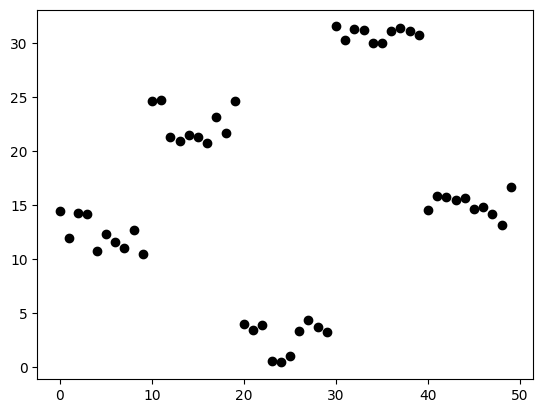

In [19]:
plot(x, y)

Now, we initialize a `gradient_booster` instance, fit it to our data, and obtain predictions on the same training data:

In [20]:
gbm = gradient_booster(n_estimators = 60, eta = 0.1, min_samples_split=2, max_depth=3)

gbm.fit(x, y)
preds = gbm.predict(x)

Plotting the prediction, we will have:

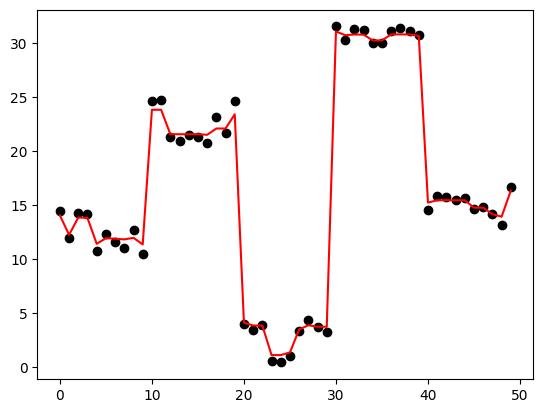

In [21]:
plot(x, y, preds)

As evident, we've overfitted to the data, highlighting the learning capacity of our developed model.

## What We Have Learned

In this discussion, we accomplished the following:

* Revisited our classification decision tree implementation and adapted it to a regression decision tree.
* Briefly reviewed the concept of boosting.
* Implemented boosted regression trees.
* Created a simple regression dataset.
* Generated predictions using the trained boosted trees and visualized them through plotting.

Hope you have enjoyed this lesson!